Here we compare Chelsea's PS1 data sent my way on July 17, 2017 (it was probably part of DR1), and the DR2 single-epoch detection table, as well as forced photometry table. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [2]:
# read-in Chelsea's data ... 
input_dir = '../dp2/real_outer_join/'
lcnames = os.listdir(input_dir)


In [59]:
len(lcnames)

9258

In [20]:
# Take the lcs, and make sure that indeed the biggest amount of obs 
# is in r filter ....
tally = {'g':0,'r':0,'i':0,'z':0,'y':0}
for i in range(len(lcnames)):
    if i % 1000 == 0 : print(i)
    lcname = lcnames[i]
    lc = Table.read(input_dir+lcname, format='ascii')
    # select only ps1 data ...
    m = lc['survey'] == 'ps1'
    filters, counts  = np.unique(lc[m]['filter'].data, return_counts=True)
    # update the tally 
    for f in filters : 
        tally[f] += counts[filters==f][0]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [21]:
tally

{'g': 95641, 'i': 99641, 'r': 131426, 'y': 76582, 'z': 101331}

Ok, this proves that indeed there ought be a lot of obs in r-filter, followed by z (surprisingly!), and then g,i , and finally y .
(could always change that later...)

In [62]:
f = 'r'
Nmin = 3
results  = {'lcname':[],  'mjd':[], 'medianmag':[] , 'sigmaGmag':[]}

for i in range(len(lcnames)):
    if i % 1000 == 0 : print(i)
    lcname = lcnames[i]
    lc = Table.read(input_dir+lcname, format='ascii')
    # select only ps1 data ...
    m1 = lc['survey'] == 'ps1'
    
    # select only r-band 
    m2 = lc['filter'] == 'r'
    m_sr = m1 & m2 
    
    # add a column with an integer part of mjd to select 
    # points from the same night ... 
    lc['mjd_int'] = lc['mjd'].astype(int)

    # choose nights that have more than  Nmin obs .. 
    mjds, counts  = np.unique(lc['mjd_int'][m_sr].data, return_counts=True)
    
    # proceed only if any night has more than 5 r-band obs - otherwise 
    # don't waste time iterating over all mjds...
    if any (counts > Nmin) : 
        #print('Yes!!!')
        # for each night that had over 5 obs , calculate the sigmaG and median mag 
        for mjd in mjds[counts>Nmin] : 
            m_mjd = lc['mjd_int'] == mjd
            m_night = m1 & m2 & m_mjd 
            mag = lc['mag'][m_night].data
            
            # calculate variance using the robust estimate for stdev 
            sigmaG =  0.7413 * (np.percentile(mag,75) -np.percentile(mag,25))
            
            # store the results 
            results['lcname'].append(lcname)
            results['mjd'].append(mjd)
            results['medianmag'].append(np.median(mag))
            results['sigmaGmag'].append(sigmaG)
np.save('PS1_DR1_Chelsea_tally_photometry', results)

0


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


1000
2000
3000
4000
5000
6000
7000
8000
9000


In [65]:
Table(results).write('PS1_DR1_Chelsea_tally_photometry', format='ascii')

In [78]:
t_ch = Table.read('PS1_DR1_Chelsea_tally_photometry', format='ascii')

In [105]:
t_ch

lcname,mjd,medianmag,sigmaGmag
str11,int64,float64,float64
248292.txt,55104,21.0252205,0.21015206362500063
1708411.txt,56289,20.159689999999998,0.09664161307500098
4023205.txt,55088,20.634401,0.514879551899999
284854.txt,55796,20.3616515,0.1851053898749961
3998504.txt,55796,18.555487999999997,0.004924455900000295
1092990.txt,55799,20.179851,0.11185976077500083
2043657.txt,55863,19.029227,0.015169963200000356
4671.txt,56222,20.5960845,0.07728404617500194
2661861.txt,56507,20.1180825,0.016338807974998967


Run the same test on PS1 DR2 epochal detections table :

In [68]:
d = Table.read('S82_DR7_QSO_PS1_det_suberlak.csv', )
ids = Table.read('S82_DR7_QSO_PS1_objID_suberlak.csv')
# add info about dbID to the detections table from objids table....
det = join(ids['dbID', 'objID'], d)
# count how many obs are in each filter...
values,count = np.unique(det['filterID'].data, return_counts=True)

In [215]:
# count how many obs are in each filter...
values,count = np.unique(det['filterID'].data, return_counts=True)

In [217]:
values

array([1, 2, 3, 4, 5])

In [216]:
count  # grizy 

array([ 94979, 133849, 177230,  95142,  73764])

So interestingly, in detection table,  there's biggest amount of 'obs in `i` (177k), followed by `r` (133k), close `g` (95k) and `z` (95k), and `y` (73k) the least. 

In [102]:
# run a similar check as for Chelsea's data ...

Nmin = 3
results  = {'dbID':[],  'mjd':[], 'medianmag':[] , 'sigmaGmag':[]}

# add a column with an integer part of mjd to select 
# points from the same night ... 
det['mjd_int'] = det['obstime'].astype(int)


# make sure to remove the negative fluxes...
det = det[det['psfflux'] > 0]

# calculate AB  magnitudes from fluxes 
# for AB mag , since fluxes are in Janskys ,  the zp is 8.9 
det['psfmag'] = -2.5* np.log10(det['psfflux'])  +  8.9 
det['psfmagErr'] = (5.0 / (2*np.log(10))) * (det['psffluxErr'] / det['psfflux'])    


for dbID in np.unique(det['dbID']) : 
    
    # select only data for that quasar .
    m1 = det['dbID'] == dbID
    
    # select only r-band  : grizy == 12345
    m2 = det['filterID'] == 2
    
    # pick that part of det table as a r-band light curve for 
    # this quasar 
    lc = det[m1&m2].copy()

    # choose nights that have more than  Nmin obs .. 
    mjds, counts  = np.unique(lc['mjd_int'].data, return_counts=True)
    
    # proceed only if any night has more than Nmin r-band obs 
    if any (counts > Nmin) : 
        # for each night that had over 5 obs , calculate the sigmaG and median mag 
        for mjd in mjds[counts>Nmin] : 
            m_mjd = lc['mjd_int'] == mjd
            mag = lc['psfmag'][m_mjd].data
            
            # calculate variance using the robust estimate for stdev 
            sigmaG =  0.7413 * (np.percentile(mag,75) -np.percentile(mag,25))
            
            # store the results 
            results['dbID'].append(dbID)
            results['mjd'].append(mjd)
            results['medianmag'].append(np.median(mag))
            results['sigmaGmag'].append(sigmaG)
np.save('PS1_DR2_epochal_detections_var', results)

In [103]:
t_det = Table(results)
t_det.write('PS1_DR2_epochal_detections_var.txt', format='ascii')

In [104]:
t_det

dbID,mjd,medianmag,sigmaGmag
int64,int64,float64,float64
1018,55088,19.91038839628462,0.09086150620202602
1018,55098,19.90033780595468,0.024121811455705747
1018,55102,19.84812717955631,0.007619393178324718
1018,55104,19.843007154007363,0.007293485626656723
1540,56222,19.07532381192247,0.03879950701672454
2113,56205,20.249702867399996,0.07669568292127392
2866,56205,19.822098691611597,0.0598848197824775
2866,56587,19.604120692066275,0.04855535819130762
2867,56205,19.286913800229435,0.014263889622803496


Finally, calculate the same for the forced photometry table : 

In [106]:
f = Table.read('S82_DR7_QSO_PS1_fp_suberlak.csv', )

In [108]:
# add info about dbID to the detections table from objids table....
fp = join(ids['dbID', 'objID'], f)

In [109]:
len(f)

697582

In [110]:
len(fp)

697582

In [222]:
# count how many obs are in each filter...
values,count = np.unique(f['filterID'].data, return_counts=True)

In [223]:
values

array([1, 2, 3, 4, 5])

In [224]:
count

array([110429, 152977, 203626, 112219, 118331])

Same general trends as for epochal detections table:  most data points in `i` (203k), followed by `r` (153k),...

In [116]:
fp[:4]

dbID,objID,raMean,decMean,detectID,obstime,exptime,airmass,Fpsfflux,FpsffluxErr,FpsfQf,FpsfQfPerfect,FpsfChiSq,zp,FapFlux,FapFluxErr,forcedWarpID,filterID,Fsky,Fskyerr,Finfoflag,Finfoflag2,Finfoflag3
int64,int64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,int64,int64
2118903,106480354410353457,35.44106937,-1.26409985,2476399375857750312,55484.4213599,45,1.12371003627777,3.1379699066747e-05,1.37226004426338e-06,0.997979998588562,0.997979998588562,1.08745002746582,24.6077003479004,3.43157989846077e-05,6.62104014281795e-07,41762570,3,-1.51439998319347e-08,1.92465995496605e-06,169869825,0,124781568
2118903,106480354410353457,35.44106937,-1.26409985,2476399394916667688,55484.4105659,45,1.14936995506287,2.95112004096154e-05,1.28339002003486e-06,0.998162984848022,0.998162984848022,1.00663995742798,24.5995006561279,2.7990799935651e-05,5.99700001657766e-07,41762569,3,6.5697399520559e-08,1.96752989722881e-06,169869825,0,24118272
2118903,106480354410353457,35.44106937,-1.26409985,2476396721031090472,55851.5191377,45,1.15383994579315,2.27222008106764e-05,1.75742002284096e-06,0.997923970222473,0.997923970222473,0.993362009525299,24.5891990661621,2.3729899112368e-05,5.54038990685513e-07,41762568,3,2.90123001178699e-08,2.96062989946222e-06,169869825,0,7341056
2118903,106480354410353457,35.44106937,-1.26409985,2476396776597229864,55851.5070238,45,1.12436997890472,2.48484993790044e-05,1.86670001767197e-06,0.997156977653503,0.994170010089874,1.05404996871948,24.6023998260498,3.0214199796319e-05,6.19202012330788e-07,41762567,3,-2.48636013111536e-07,2.58896989180357e-06,169869825,0,7341056


In [117]:
# run a similar check as for Chelsea's data ...
Nmin = 3
results  = {'dbID':[],  'mjd':[], 'medianmag':[] , 'sigmaGmag':[]}

# add a column with an integer part of mjd to select 
# points from the same night ... 
fp['mjd_int'] = fp['obstime'].astype(int)


# make sure to remove the negative fluxes...
fp.remove_rows(fp['Fpsfflux'] < 0)

# calculate AB  magnitudes from fluxes 
# for AB mag , since fluxes are in Janskys ,  the zp is 8.9 
fp['psfmag'] = -2.5* np.log10(fp['Fpsfflux'])  +  8.9 
fp['psfmagErr'] = (5.0 / (2*np.log(10))) * (fp['FpsffluxErr'] / fp['Fpsfflux'])    


for dbID in np.unique(fp['dbID']) : 
    
    # select only data for that quasar .
    m1 = fp['dbID'] == dbID
    
    # select only r-band  : grizy == 12345
    m2 = fp['filterID'] == 2
    
    # pick that part of det table as a r-band light curve for 
    # this quasar 
    lc = fp[m1&m2].copy()

    # choose nights that have more than  Nmin obs .. 
    mjds, counts  = np.unique(lc['mjd_int'].data, return_counts=True)
    
    # proceed only if any night has more than Nmin r-band obs 
    if any (counts > Nmin) : 
        # for each night that had over 5 obs , calculate the sigmaG and median mag 
        for mjd in mjds[counts>Nmin] : 
            m_mjd = lc['mjd_int'] == mjd
            mag = lc['psfmag'][m_mjd].data
            
            # calculate variance using the robust estimate for stdev 
            sigmaG =  0.7413 * (np.percentile(mag,75) -np.percentile(mag,25))
            
            # store the results 
            results['dbID'].append(dbID)
            results['mjd'].append(mjd)
            results['medianmag'].append(np.median(mag))
            results['sigmaGmag'].append(sigmaG)
np.save('PS1_DR2_fp_detections_var', results)

In [197]:
len(t_det)

5364

In [118]:
t_fp = Table(results)
t_fp.write('PS1_DR2_fp_detections_var.txt', format='ascii')

In [196]:
len(t_fp)

13317

Make the plots we talked about ... 

In [123]:
# first, make a new identifier :
# dbID +  mjd,  because need to treat each day as a separate point ... 

t_ch['dbID'] = np.array([int(x[:-4]) for x in t_ch['lcname'].data])
t_ch['dbIDmjd'] = np.array([str(r['dbID'])+'_'+str(r['mjd']) for r in t_ch])

In [136]:
# do the same for the detections and fp
t_det['dbIDmjd'] = np.array([str(r['dbID'])+'_'+str(r['mjd']) for r in t_det])
t_fp['dbIDmjd'] = np.array([str(r['dbID'])+'_'+str(r['mjd']) for r in t_fp])

In [137]:
# check how many days that had over Nmin obs in Chelsea's data also had more than
# that in detections, and fp...
np.sum(np.in1d(t_ch['dbIDmjd'], t_det['dbIDmjd']))

2970

In [138]:
np.sum(np.in1d(t_ch['dbIDmjd'], t_fp['dbIDmjd']))

2668

In [140]:
# join to plot the results .... 

t_ch_det = join(t_ch, t_det, keys='dbIDmjd',table_names=['ch','det'] )


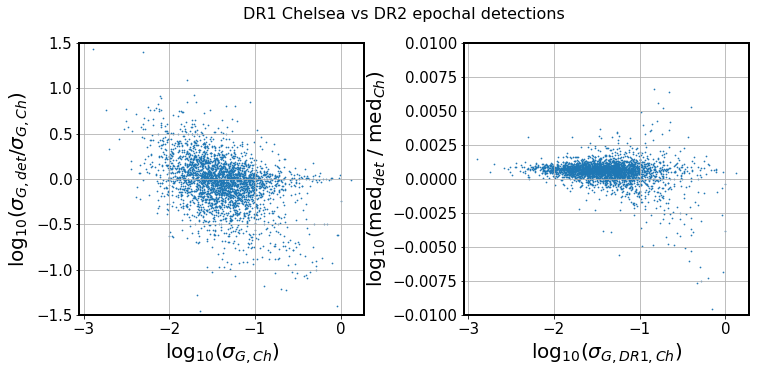

In [214]:
%matplotlib inline
fig,ax  = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(np.log10(t_ch_det['sigmaGmag_ch'].data), 
              np.log10(t_ch_det['sigmaGmag_det'].data / t_ch_det['sigmaGmag_ch'].data),
              s=0.5) 
ax[0].set_xlabel(r'$\log_{10}{(\sigma_{G,Ch})}$')
ax[0].set_ylabel(r'$\log_{10}{(\sigma_{G,det} / \sigma_{G,Ch})}$')


ax[1].scatter(np.log10(t_ch_det['sigmaGmag_ch'].data), 
             np.log10(t_ch_det['medianmag_det'].data  / t_ch_det['medianmag_ch'].data),
             s = 0.5)
ax[1].set_xlabel(r'$\log_{10}{(\sigma_{G,DR1,Ch})}$')
ax[1].set_ylabel(r'$\log_{10}($'+'med'+r'$_{det}$'+' / med'+r'$_{Ch})}$')

fig.subplots_adjust(wspace=0.35)
ax[1].grid()
ax[0].grid()
#ax[0].set_xlim(0,1)
#ax[1].set_xlim(0,1)
#ax[0].set_ylim(-4,0)
ax[0].set_ylim(-1.5,1.5)
ax[1].set_ylim(-0.01,0.01)

fig.suptitle('DR1 Chelsea vs DR2 epochal detections', fontsize=16)
plt.savefig('PS1_DR1_vs_DR2_det.png',bbox_inches='tight', dpi=100)

In [188]:
# join Chelsea's to fp ... 
t_ch_fp = join(t_ch, t_fp, keys='dbIDmjd',table_names=['ch','fp'] )



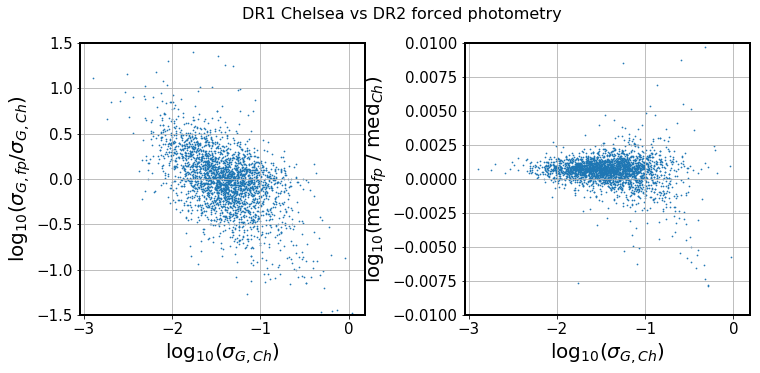

In [213]:
%matplotlib inline
fig,ax  = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(np.log10(t_ch_fp['sigmaGmag_ch'].data), 
              np.log10(t_ch_fp['sigmaGmag_fp'].data / t_ch_fp['sigmaGmag_ch'].data),
              s=0.5) 
ax[0].set_xlabel(r'$\log_{10}{(\sigma_{G,Ch})}$')
ax[0].set_ylabel(r'$\log_{10}{(\sigma_{G,fp} / \sigma_{G,Ch})}$')


ax[1].scatter(np.log10(t_ch_fp['sigmaGmag_ch'].data), 
             np.log10(t_ch_fp['medianmag_fp'].data  / t_ch_fp['medianmag_ch'].data),
             s = 0.5)
ax[1].set_xlabel(r'$\log_{10}{(\sigma_{G,Ch})}$')
ax[1].set_ylabel(r'$\log_{10}($'+'med'+r'$_{fp}$'+' / med'+r'$_{Ch})}$')

fig.subplots_adjust(wspace=0.35)
ax[1].grid()
ax[0].grid()
#ax[0].set_xlim(0,1)
#ax[1].set_xlim(0,1)
#ax[0].set_ylim(-4,0)
#ax[1].set_ylim(-3,0)
ax[0].set_ylim(-1.5,1.5)
ax[1].set_ylim(-0.01,0.01)
fig.suptitle('DR1 Chelsea vs DR2 forced photometry ', fontsize=16)
plt.savefig('PS1_DR1_vs_DR2_fp.png',bbox_inches='tight', dpi=100)

In [192]:
# finally, compare the detections table to forced photometry...

t_det_fp = join(t_det, t_fp, keys='dbIDmjd',table_names=['det','fp'] )


In [194]:
t_det_fp

dbID_det,mjd_det,medianmag_det,sigmaGmag_det,dbIDmjd,dbID_fp,mjd_fp,medianmag_fp,sigmaGmag_fp
int64,int64,float64,float64,str13,int64,int64,float64,float64
1000743,56971,18.437094469521924,0.010632793918349545,1000743_56971,1000743,56971,18.423701670135074,0.04158402958973871
1002076,56207,19.64718453537652,0.040196424050469755,1002076_56207,1002076,56207,19.63178893021961,0.06288739300647277
1002162,56971,18.13940467424328,0.008592053640277902,1002162_56971,1002162,56971,18.13318185325245,0.015437084562250781
1002453,55467,20.08408823210155,0.06562640378645229,1002453_55467,1002453,55467,20.08584121192964,0.029715740464016663
100286,55088,20.28434869030897,0.03584975178448118,100286_55088,100286,55088,20.300440037260927,0.019912400985915873
100286,55094,20.27164786221297,0.04166554712234206,100286_55094,100286,55094,20.296984919438724,0.08898984900310934
100286,56205,19.962063731713428,0.020582018600915207,100286_56205,100286,56205,19.955969471421618,0.03565472615508518
1003180,56971,19.91632076224637,0.0640850940947326,1003180_56971,1003180,56971,19.9137162301882,0.03910336997321583
1003235,56971,20.25810595184134,0.13804394213474672,1003235_56971,1003235,56971,20.25222653637013,0.09580663765079454


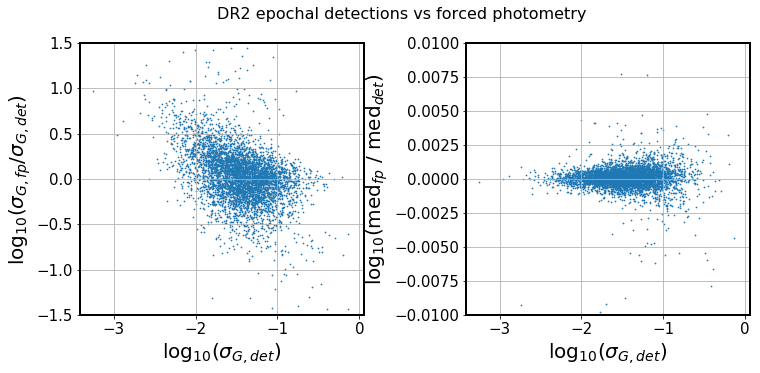

In [212]:
%matplotlib inline
fig,ax  = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(np.log10(t_det_fp['sigmaGmag_det'].data), 
              np.log10(t_det_fp['sigmaGmag_fp'].data / t_det_fp['sigmaGmag_det'].data),
              s=0.5) 
ax[0].set_xlabel(r'$\log_{10}{(\sigma_{G,det})}$')
ax[0].set_ylabel(r'$\log_{10}{(\sigma_{G,fp} / \sigma_{G,det})}$')


ax[1].scatter(np.log10(t_det_fp['sigmaGmag_det'].data), 
             np.log10(t_det_fp['medianmag_fp'].data  / t_det_fp['medianmag_det'].data),
             s = 0.5)
ax[1].set_xlabel(r'$\log_{10}{(\sigma_{G,det})}$')
ax[1].set_ylabel(r'$\log_{10}($'+'med'+r'$_{fp}$'+' / med'+r'$_{det})}$')

fig.subplots_adjust(wspace=0.36)
ax[1].grid()
ax[0].grid()
#ax[0].set_xlim(0,1)
#ax[1].set_xlim(0,1)
ax[0].set_ylim(-1.5,1.5)
#ax[1].set_ylim(-3,0)
ax[1].set_ylim(-0.01,0.01)
fig.suptitle('DR2 epochal detections vs forced photometry ', fontsize=16)
plt.savefig('PS1_DR2_det_vs_fp.png',bbox_inches='tight', dpi=100)

Plot $\sigma_{G}$ vs $median$ magnitude for DR1 , DR2 det and DR2 fp : 

In [227]:
t_det[:4]

dbID,mjd,medianmag,sigmaGmag,dbIDmjd
int64,int64,float64,float64,str13
1018,55088,19.91038839628462,0.09086150620202602,1018_55088
1018,55098,19.90033780595468,0.024121811455705747,1018_55098
1018,55102,19.84812717955631,0.007619393178324718,1018_55102
1018,55104,19.843007154007363,0.007293485626656723,1018_55104


In [228]:
t_fp[:4]

dbID,mjd,medianmag,sigmaGmag,dbIDmjd
int64,int64,float64,float64,str13
1018,55088,19.88409464624803,0.06678768071464912,1018_55088
1018,55094,19.94110305330233,0.11014588796146901,1018_55094
1018,55098,19.880980558520974,0.018887974986306493,1018_55098
1018,55102,19.855829010147005,0.009267929668149507,1018_55102


In [229]:
ax

lcname,mjd,medianmag,sigmaGmag,dbID,dbIDmjd
str11,int64,float64,float64,int64,str13
248292.txt,55104,21.0252205,0.21015206362500063,248292,248292_55104
1708411.txt,56289,20.159689999999998,0.09664161307500098,1708411,1708411_56289
4023205.txt,55088,20.634401,0.514879551899999,4023205,4023205_55088
284854.txt,55796,20.3616515,0.1851053898749961,284854,284854_55796


1.0 26.0
1.0 40.0
1.0 82.0


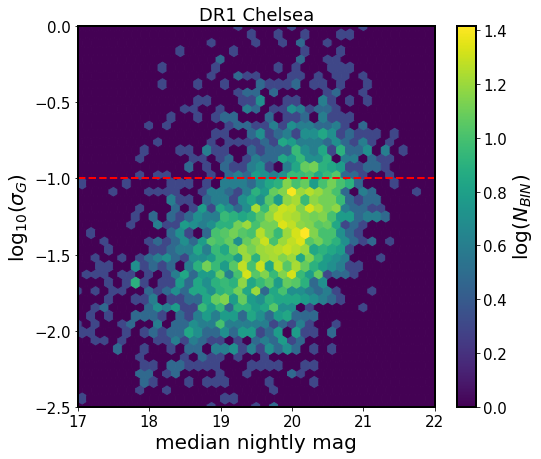

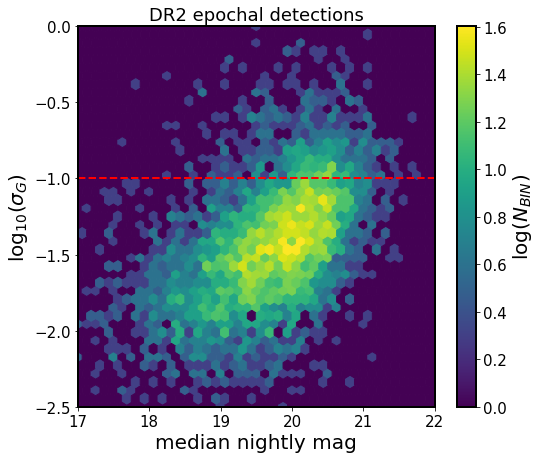

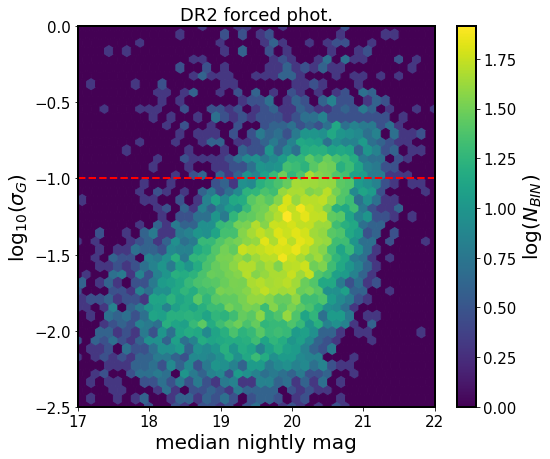

In [271]:
import matplotlib as mpl
titles = ['DR1 Chelsea', 'DR2 epochal detections', 'DR2 forced phot.']

i = 0 
for t in [t_ch, t_det, t_fp]:#
    #fig,ax = plt.subplots(1,2,figsize=(15,7))
    fig,ax = plt.subplots(1,1,figsize=(8,7))
    image = ax.hexbin(t['medianmag'].data, np.log10(t['sigmaGmag'].data), 
             extent=  (17,22,-2.5,0), gridsize=40, bins='log')
    #ax[1].scatter(t['medianmag'].data,t['sigmaGmag'].data, 
    #      s=0.1)
    #for i in range(len(ax)):
    ax.set_xlim(17,22)
    ax.set_ylim(-2.5,0)
    ax.set_xlabel('median nightly mag')
    ax.set_ylabel(r'$\log_{10}{(\sigma_{G})}$')
    ax.set_title(titles[i])
    ax.axhline(np.log10(0.1), ls='--', lw='2', c='r')
    vmin, vmax = image.get_clim()
    print(vmin,vmax)
    norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
    cmap.set_array([])

    plt.colorbar(mappable = cmap, orientation='vertical',
            label=r'$\log{(N_{BIN})}$')


    #plt.colorbar(image)
    plt.savefig('PS1_medmag_sigmaG_'+titles[i][:3]+'_'+str(i)+'.png',
               bbox_inches='tight',dpi=100)
    i += 1 

In [263]:
ax.hexbin?